# `Материалы кафедры ММП факультета ВМК МГУ. Введение в Эффективные Системы Глубокого Обучение.`

# `Семинар 02. Базовые методы ускорения`

### `Материалы составил Феоктистов Дмитрий (@trandelik)`

#### `Москва, Осенний семестр 2025`

О чём можно узнать из этого ноутбука:

* Automatic Mixed Precision
* Profiling
* torch.compile

При составлении семинара авторы сильно вдохновлялись [данным семинаром](https://github.com/mryab/efficient-dl-systems/tree/main/week03_fast_pipelines/seminar)

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '4'

### `Automatic Mixed Precision`

In [2]:
import torch
import torch.nn as nn
import torchvision

device = torch.device("cuda:0")

In [3]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

mnist_train = torchvision.datasets.MNIST(
    "./mnist/", train=True, download=True, transform=transform
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/", train=False, download=True, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    mnist_train, batch_size=1024, shuffle=True
)
val_dataloader = torch.utils.data.DataLoader(
    mnist_val, batch_size=1024, shuffle=False
)

In [4]:
from train import model_provider, train, train_amp

Посмотрим на обучение в fp32

In [5]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, n_epochs=1)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.17651556432247162, accuracy: 0.9452905654907227


In [6]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, n_epochs=3)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.14890363812446594, accuracy: 0.951433002948761


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.06845909357070923, accuracy: 0.9774673581123352


Теперь посмотрим на обучение в fp16

In [7]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, precision="half", n_epochs=1)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: nan, accuracy: 0.09818439185619354


Обучение разойдется из-за проблем с делением на очень маленькое числов в Adam

In [8]:
print("Master parameters dtype: {}".format(optimizer.param_groups[0]["params"][0][0].dtype))
print("Optimizer first moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg"].dtype))
print("Optimizer second moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg_sq"].dtype))

Master parameters dtype: torch.float16
Optimizer first moment dtype: torch.float16
Optimizer second moment dtype: torch.float16


Посмотрим на поведение оптимизатора, в котором нет деления

In [9]:
model = model_provider()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, precision="half", n_epochs=3)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 1.2169268131256104, accuracy: 0.5715581178665161


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.16140714287757874, accuracy: 0.9487005472183228


На самом деле в данном случае проблема связана с `eps`

In [10]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, eps=1e-4)
loss = nn.CrossEntropyLoss()

train(model, loss, optimizer, train_dataloader, val_dataloader, precision="half", n_epochs=3)

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 2.3055665493011475, accuracy: 0.11364994943141937


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 2.314523696899414, accuracy: 0.10305126011371613


Но этого может быть недостаточно, и тогда нам на помощь придет AMP

[Список CUDA операций, которые можно вычислять в fp16]((https://pytorch.org/docs/stable/amp.html#cuda-ops-that-can-autocast-to-float16)).

\_\_matmul\_\_, addbmm, addmm, addmv, addr, baddbmm, bmm, chain_matmul, multi_dot, conv1d, conv2d, conv3d, conv_transpose1d, conv_transpose2d, conv_transpose3d, GRUCell, linear, LSTMCell, matmul, mm, mv, prelu, RNNCell

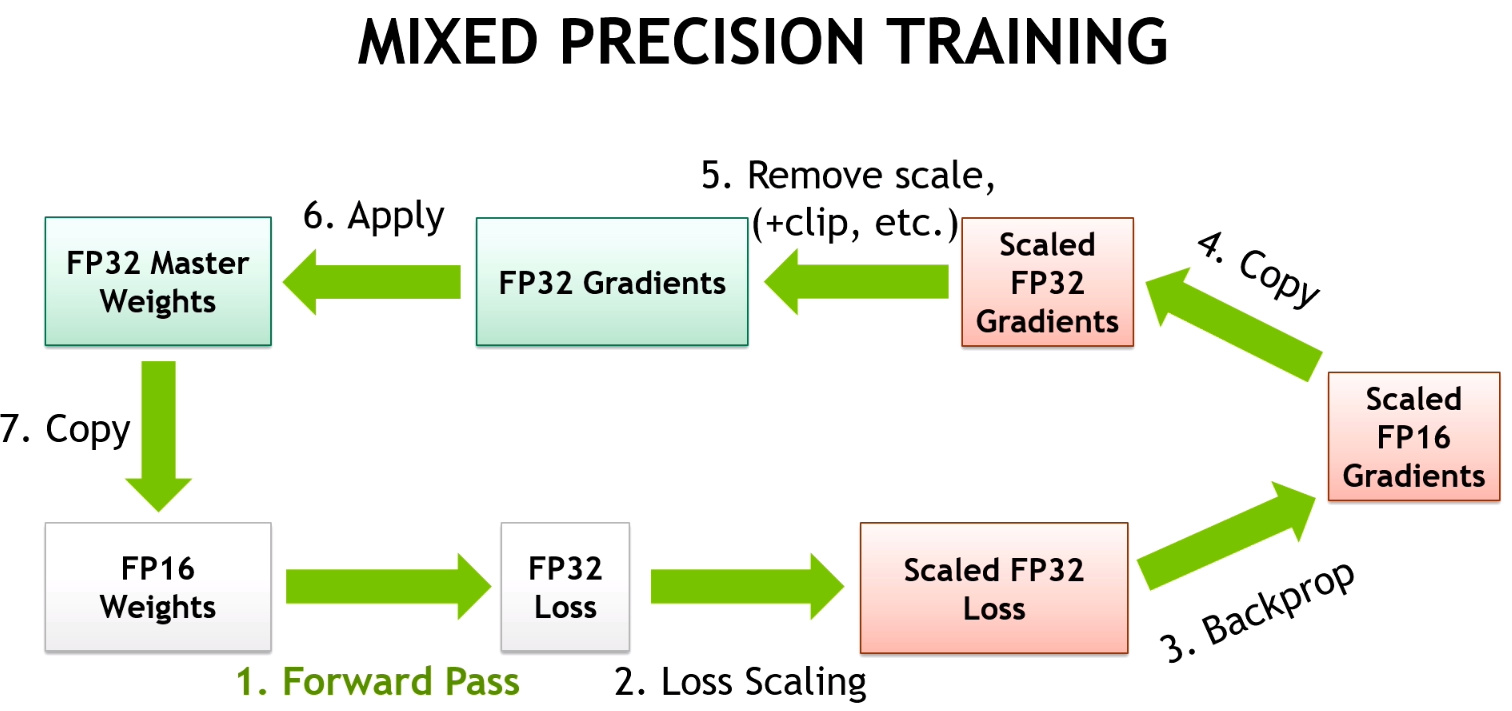

In [11]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train_amp(model, loss, optimizer, train_dataloader, val_dataloader, loss_scaling=False, precision="fp16")

/home/trandelik/efficient-dl-systems/week03_fast_pipelines/seminar/train.py:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.13943623006343842, accuracy: 0.9538504481315613


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.07477988302707672, accuracy: 0.9745973348617554


In [12]:
print("Master parameters dtype: {}".format(optimizer.param_groups[0]["params"][0][0].dtype))
print("Optimizer first moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg"].dtype))
print("Optimizer second moment dtype: {}".format(optimizer.state_dict()["state"][0]["exp_avg_sq"].dtype))

Master parameters dtype: torch.float32
Optimizer first moment dtype: torch.float32
Optimizer second moment dtype: torch.float32


In [13]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train_amp(model, loss, optimizer, train_dataloader, val_dataloader, loss_scaling=True, precision="fp16")

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.23714229464530945, accuracy: 0.9206512570381165


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.11853484809398651, accuracy: 0.963151752948761


In [14]:
model = model_provider()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()

train_amp(model, loss, optimizer, train_dataloader, val_dataloader, loss_scaling=False, precision="bf16")

Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 0, loss: 0.15199849009513855, accuracy: 0.9511181116104126


Epoch 1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/59 [00:00<?, ?it/s]

Starting validation...
Epoch: 2, loss: 0.10093364864587784, accuracy: 0.9681002497673035


Как можно заметить, время работы особо не отличается (почему?)

Теперь попробуем замерить время честно

In [15]:
import gc
from time import time

import torch
import torch.nn as nn
from tqdm.auto import tqdm, trange

device = torch.device("cuda:0")

start_time = None

batch_size = 512  # Try, for example, 128, 256, 513
in_size = 4096 + 2048
out_size = 4096 + 2048
num_layers = 3
num_batches = 50
epochs = 3


def start_timer():
    global start_time
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()
    start_time = time()


def end_timer_and_print(local_msg):
    torch.cuda.synchronize()
    end_time = time()
    print("\n" + local_msg)
    print(f"Total execution time = {end_time - start_time:.3f} sec")
    print(
        f"Max memory used by tensors = {torch.cuda.max_memory_allocated() // 1_000_000} megabytes"
    )

def make_model(in_size: int, out_size: int, num_layers: int) -> torch.nn.Module:
    layers = []
    for _ in range(num_layers - 1):
        layers.append(torch.nn.Linear(in_size, in_size))
        layers.append(torch.nn.ReLU())
    layers.append(torch.nn.Linear(in_size, out_size))
    return torch.nn.Sequential(*tuple(layers))

In [16]:
data = [torch.randn(batch_size, in_size, device=device) for _ in range(num_batches)]
targets = [torch.randn(batch_size, out_size, device=device) for _ in range(num_batches)]
loss_fn = torch.nn.MSELoss().to(device)

In [17]:
net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input)
        loss = loss_fn(output, target)
        loss.backward()
        opt.step()
        opt.zero_grad()  # set_to_none=True here can modestly improve performance
end_timer_and_print("Full precision:")

  0%|          | 0/3 [00:00<?, ?it/s]


Full precision:
Total execution time = 2.845 sec
Max memory used by tensors = 2221 megabytes


In [18]:
net = make_model(in_size, out_size, num_layers)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
net.half().to(device)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        output = net(input.half())
        loss = loss_fn(output, target.half())
        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Half precision:")

  0%|          | 0/3 [00:00<?, ?it/s]


Half precision:
Total execution time = 0.350 sec
Max memory used by tensors = 2013 megabytes


In [19]:
net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        loss.backward()
        opt.step()
        opt.zero_grad()
end_timer_and_print("Mixed precision without scaling:")

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision without scaling:
Total execution time = 0.519 sec
Max memory used by tensors = 2278 megabytes


In [20]:
net = make_model(in_size, out_size, num_layers).to(device)
opt = torch.optim.SGD(net.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler(enabled=True)

start_timer()
for epoch in trange(epochs):
    for input, target in zip(data, targets):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net(input)
            # output is float16 because linear layers autocast to float16.
            assert output.dtype is torch.float16

            loss = loss_fn(output, target)
            # loss is float32 because mse_loss layers autocast to float32.
            assert loss.dtype is torch.float32

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        opt.zero_grad()
end_timer_and_print("Mixed precision with scaling:")

/var/tmp/ipykernel_3133210/325995577.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision with scaling:
Total execution time = 0.631 sec
Max memory used by tensors = 2485 megabytes


### `Tensor cores`

Одно из важных ограничений для активации тензорных ядер заключается в том, что размерности должны быть кратны 8. Для проверки этого факта мы запустим две модели: одна будет немного больше, но при этом будет удовлетворять ограничениям для активации тензорных ядер, а другая — меньше и не будет удовлетворять этим ограничениям.

In [21]:
data_8192 = [torch.randn(512, 8192, device=device) for _ in range(num_batches)]
targets_8192 = [torch.randn(512, 8192, device=device) for _ in range(num_batches)]

data_8191 = [torch.randn(512, 8191, device=device) for _ in range(num_batches)]
targets_8191 = [torch.randn(512, 8191, device=device) for _ in range(num_batches)]

net_8192 = make_model(8192, 8192, num_layers).to(device)
opt_8192 = torch.optim.SGD(net_8192.parameters(), lr=0.001)
scaler_8192 = torch.cuda.amp.GradScaler(enabled=True)

net_8191 = make_model(8191, 8191, num_layers).to(device)
opt_8191 = torch.optim.SGD(net_8191.parameters(), lr=0.001)
scaler_8191 = torch.cuda.amp.GradScaler(enabled=True)

loss_fn = torch.nn.MSELoss().to(device)

# warmup
for epoch in trange(epochs):
    for input, target in zip(data_8192, targets_8192):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net_8192(input)

# with tensor cores
start_timer()
for epoch in trange(epochs):
    for input, target in zip(data_8192, targets_8192):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net_8192(input)
            loss = loss_fn(output, target)

        scaler_8192.scale(loss).backward()
        scaler_8192.step(opt_8192)
        scaler_8192.update()
        opt_8192.zero_grad()
end_timer_and_print("Mixed precision, in/out dim 8192:")

# without tensor cores
start_timer()
for epoch in trange(epochs):
    for input, target in zip(data_8191, targets_8191):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            output = net_8191(input)
            loss = loss_fn(output, target)
        scaler_8191.scale(loss).backward()
        scaler_8191.step(opt_8191)
        scaler_8191.update()
        opt_8191.zero_grad()
end_timer_and_print("Mixed precision, in/out dim 8191:")

/var/tmp/ipykernel_3133210/3809851713.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_8192 = torch.cuda.amp.GradScaler(enabled=True)
/var/tmp/ipykernel_3133210/3809851713.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_8191 = torch.cuda.amp.GradScaler(enabled=True)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision, in/out dim 8192:
Total execution time = 1.132 sec
Max memory used by tensors = 7661 megabytes


  0%|          | 0/3 [00:00<?, ?it/s]


Mixed precision, in/out dim 8191:
Total execution time = 1.802 sec
Max memory used by tensors = 7661 megabytes


### `Профилирование`

У профилирования две основные задачи:
- Не допускать простоя оборудования из-за взаимных ожиданий (например, процессорный боттлнек при обучении нейросетей).
- Находить самые ресурсоёмкие части кода, чтобы их можно было проанализировать и оптимизировать алгоритмически или архитектурно.

#### `py-spy` - профилировщик для Python

Для профилирования любого Python кода можно использовать `py-spy` или [`scalene`](https://github.com/plasma-umass/scalene). Основным преисуществом данного подхода является то, что нам не нужно менять исходный код, и можно подключить профилировщик к любому запущенному процессу.

Запустим обучение используя `python mnist_trainig.py`

И запустим профилировшик `sudo py-spy record -o profile.svg --pid <get_pid>`.

In [22]:
!python3 mnist_training.py --transforms-level 1 # --amp

Epoch 0: 100%|██████████████████████████████████| 59/59 [00:11<00:00,  5.27it/s]
Starting validation...
Epoch: 0, loss: 0.1338636577129364, accuracy: 0.9579221606254578
Epoch 2: 100%|██████████████████████████████████| 59/59 [00:10<00:00,  5.73it/s]
Starting validation...
Epoch: 2, loss: 0.07769663631916046, accuracy: 0.9764528274536133
Epoch 3:  19%|██████▎                           | 11/59 [00:02<00:09,  5.22it/s]
Traceback (most recent call last):
  File "/home/trandelik/efficient-dl-systems/week03_fast_pipelines/seminar/mnist_training.py", line 86, in <module>
    train(model_, loss_fn, optimizer, train_dataloader_, val_dataloader_, n_epochs=args.n_epochs)
  File "/home/trandelik/efficient-dl-systems/week03_fast_pipelines/seminar/train.py", line 42, in train
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
  File "/home/trandelik/micromamba/envs/tabm/lib/python3.10/site-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/home/

#### `Deep learning profiling: PyTorch profiler`


[Советуем заглянуть сюда](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html).

In [23]:
import torch
import torchvision.models as models
from torch.profiler import ProfilerActivity, profile, record_function

Будем профилировать все - GPU, CPU вычисления и даже память, а для визуализации будем использовать [perfetto.ui](https://ui.perfetto.dev/).

In [24]:
model = model_provider()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

with profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    with_stack=True,
) as prof:
    epoch = 0
    model.train()
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        prof.step()

prof.export_chrome_trace("trace.json")

/var/tmp/ipykernel_3133210/1282781177.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

##### `CPU Activities`

In [25]:
model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

In [26]:
print(
    prof.key_averages().table(
        sort_by="cpu_time_total", row_limit=10
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         0.18%       8.095ms       100.00%        4.385s        4.385s             1  
                     aten::conv2d         0.01%     270.869us        47.23%        2.071s     103.567ms            20  
                aten::convolution         0.02%     738.858us        47.23%        2.071s     103.553ms            20  
               aten::_convolution         0.01%     490.139us        47.21%        2.070s     103.516ms            20  
         aten::mkldnn_convolution        47.18%        2.069s        47.20%        2.070s     103.492ms            20  
                 aten::batch_norm       

In [27]:
print(
    prof.key_averages(group_by_input_shape=True).table(
        sort_by="cpu_time_total", row_limit=10
    )
)

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                  model_inference         0.18%       8.095ms       100.00%        4.385s        4.385s             1                                                                                []  
                     aten::conv2d         0.00%      52.840us         9.47%     415.363ms     103.841ms             4                             [[5, 64, 56, 56], [64, 64, 3, 3], [], [], [], 

##### `CPU + CUDA Activities`

In [30]:
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True
) as prof:
    with record_function("model_inference_1"):
        model(inputs)

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                model_inference_1         0.16%       7.009ms        99.98%        4.392s        4.392s             1  
                     aten::conv2d         0.00%     212.200us        47.42%        2.083s     104.156ms            20  
                aten::convolution         0.01%     634.905us        47.42%        2.083s     104.145ms            20  
               aten::_convolution         0.01%     402.268us        47.40%        2.082s     104.113ms            20  
         aten::mkldnn_convolution        47.38%        2.081s        47.39%        2.082s     104.093ms            20  
                      aten::empty       

#### `Memory profiling`

In [31]:
with profile(
    activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True
) as prof:
    model(inputs)

print(prof.key_averages(group_by_input_shape=True).table(sort_by="self_cuda_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls                                                                      Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                     aten::conv2d         0.00%      14.460us         1.59%      69.768ms      69.768ms      15.31 MB           0 B             1                             [[5, 3, 224, 224], [64, 3, 7, 7], [], [], [], [], []]  
                aten::convolution         0.00%      65.159us         1.59%     

Сделаем снэпшот памяти ([Understanding CUDA Memory Usage](https://pytorch.org/docs/stable/torch_cuda_memory.html)) и изучим, как выделяется память при обучении с AMP и без него.

In [32]:
!python3 memory_snapshot.py

[W919 14:35:30.933781808 unwind.cpp:219] Warning: Unsupported unwinding pattern: Address not in range (function unwinderFor)
/home/trandelik/efficient-dl-systems/week03_fast_pipelines/seminar/memory_snapshot.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


In [33]:
!python3 memory_snapshot.py --amp

[W919 14:36:01.671599162 unwind.cpp:219] Warning: Unsupported unwinding pattern: Address not in range (function unwinderFor)
/home/trandelik/efficient-dl-systems/week03_fast_pipelines/seminar/memory_snapshot.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


### `torch.compile`

Для начала скомпилируем модель

In [34]:
model = model_provider()
model.to(device)
model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

with profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    with_stack=True,
) as prof:
    epoch = 0
    model.train()
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        prof.step()

prof.export_chrome_trace("trace_compile.json")

/var/tmp/ipykernel_3133210/1873066538.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

А теперь еще и шаг оптимизатора

In [35]:
model = model_provider()
model.to(device)
model = torch.compile(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
optimizer.step = torch.compile(optimizer.step)

with profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    record_shapes=True,
    with_stack=True,
) as prof:
    epoch = 0
    model.train()
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch}: "):
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        prof.step()

prof.export_chrome_trace("trace_fused_adam.json")

/var/tmp/ipykernel_3133210/1230627274.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 0:   0%|          | 0/59 [00:00<?, ?it/s]

W0919 14:55:11.280000 3133210 site-packages/torch/_logging/_internal.py:1154] [1/0] Profiler function <class 'torch.autograd.profiler.record_function'> will be ignored
